# **Project**
**Tittle: A Quantitative Analysis of U.S. Equities: Forecasting
with PCA and Linear Regression.**

***Problem Question***

**Which types of stocks — stable vs. volatile — are most suitable for prediction with PCA and regression models, and what are the implications for long-term portfolio strategy?**

In [47]:
#Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

In [8]:
#tickers
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "META", "NVDA", "TSLA", "JPM", "JNJ", "PG"]

# Download daily data
df = yf.download(tickers, start="2015-01-01", end="2025-01-01")

# Reset index to get 'Date' column
df = df.reset_index()

# structure
df_close = df[["Date"]].copy()
for ticker in tickers:
    df_close[ticker] = df["Close"][ticker]

df_close.head()


/tmp/ipython-input-2922734607.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers, start="2015-01-01", end="2025-01-01")
[*********************100%***********************]  10 of 10 completed


Price,Date,AAPL,MSFT,GOOGL,AMZN,META,NVDA,TSLA,JPM,JNJ,PG
Ticker,,,,,,,,,,,
0,2015-01-02,24.261042,39.933060,26.319653,15.4260,78.021957,0.483066,14.620667,46.948082,78.012611,66.983513
1,2015-01-05,23.577574,39.565834,25.818159,15.1095,76.768845,0.474907,14.006000,45.490585,77.467766,66.665031
2,2015-01-06,23.579790,38.985115,25.180983,14.7645,75.734520,0.460508,14.085333,44.311050,77.087090,66.361359
3,2015-01-07,23.910435,39.480450,25.106924,14.9210,75.734520,0.459308,14.063333,44.378677,78.788841,66.709457
4,2015-01-08,24.829126,40.641876,25.194403,15.0230,77.753433,0.476586,14.041333,45.370361,79.408379,67.472328


**Finding a Log Return**

In [9]:
# Setting Date as index
df_close = df_close.set_index("Date").dropna()

#Calculation of the Log Returns
df_returns = (df_close.apply(lambda x: np.log(x) - np.log(x.shift(1)))).iloc[1:]
df_returns.head()


Price,AAPL,MSFT,GOOGL,AMZN,META,NVDA,TSLA,JPM,JNJ,PG
Ticker,,,,,,,,,,
Date,,,,,,,,,,
2015-01-05,-0.028576,-0.009239,-0.019238,-0.020731,-0.016191,-0.017034,-0.042950,-0.031537,-0.007009,-0.004766
2015-01-06,0.000094,-0.014786,-0.024989,-0.023098,-0.013565,-0.030788,0.005648,-0.026271,-0.004926,-0.004566
2015-01-07,0.013925,0.012626,-0.002945,0.010544,0.000000,-0.002609,-0.001563,0.001525,0.021836,0.005232
2015-01-08,0.037702,0.028993,0.003478,0.006813,0.026309,0.036927,-0.001566,0.022100,0.007833,0.011371
2015-01-09,0.001072,-0.008441,-0.012287,-0.011818,-0.005644,0.004020,-0.018981,-0.017540,-0.013723,-0.009375


**ADF Test**

In [10]:
from statsmodels.tsa.stattools import adfuller

for stock in df_returns.columns:
    result = adfuller(df_returns[stock].dropna())
    print(f"{stock}: ADF Statistic = {result[0]:.4f}, p-value = {result[1]:.4f}")


('AAPL', ''): ADF Statistic = -15.5495, p-value = 0.0000
('MSFT', ''): ADF Statistic = -17.2838, p-value = 0.0000
('GOOGL', ''): ADF Statistic = -17.2211, p-value = 0.0000
('AMZN', ''): ADF Statistic = -50.6739, p-value = 0.0000
('META', ''): ADF Statistic = -17.2357, p-value = 0.0000
('NVDA', ''): ADF Statistic = -16.2749, p-value = 0.0000
('TSLA', ''): ADF Statistic = -34.3185, p-value = 0.0000
('JPM', ''): ADF Statistic = -13.2278, p-value = 0.0000
('JNJ', ''): ADF Statistic = -12.8895, p-value = 0.0000
('PG', ''): ADF Statistic = -13.5261, p-value = 0.0000


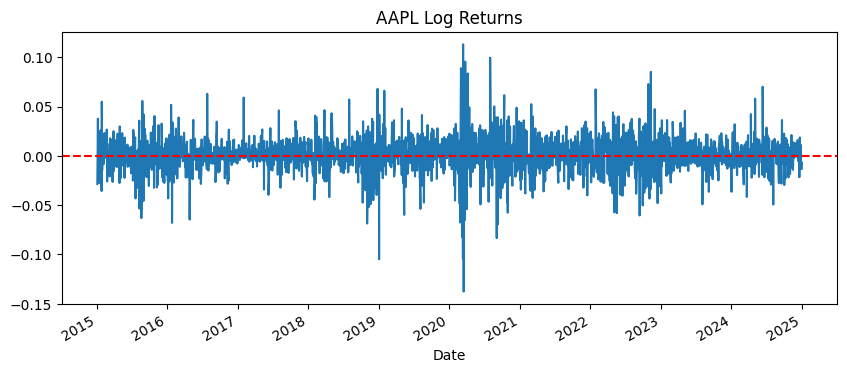

In [11]:
import matplotlib.pyplot as plt

df_returns["AAPL"].plot(figsize=(10,4), title="AAPL Log Returns")
plt.axhline(0, color="red", linestyle="--")
plt.show()


**Calculating the 252-day moving average Prediction**

In [12]:
# Calculate the 252-day moving average
movingAverage = df_close.rolling(window=252).mean()

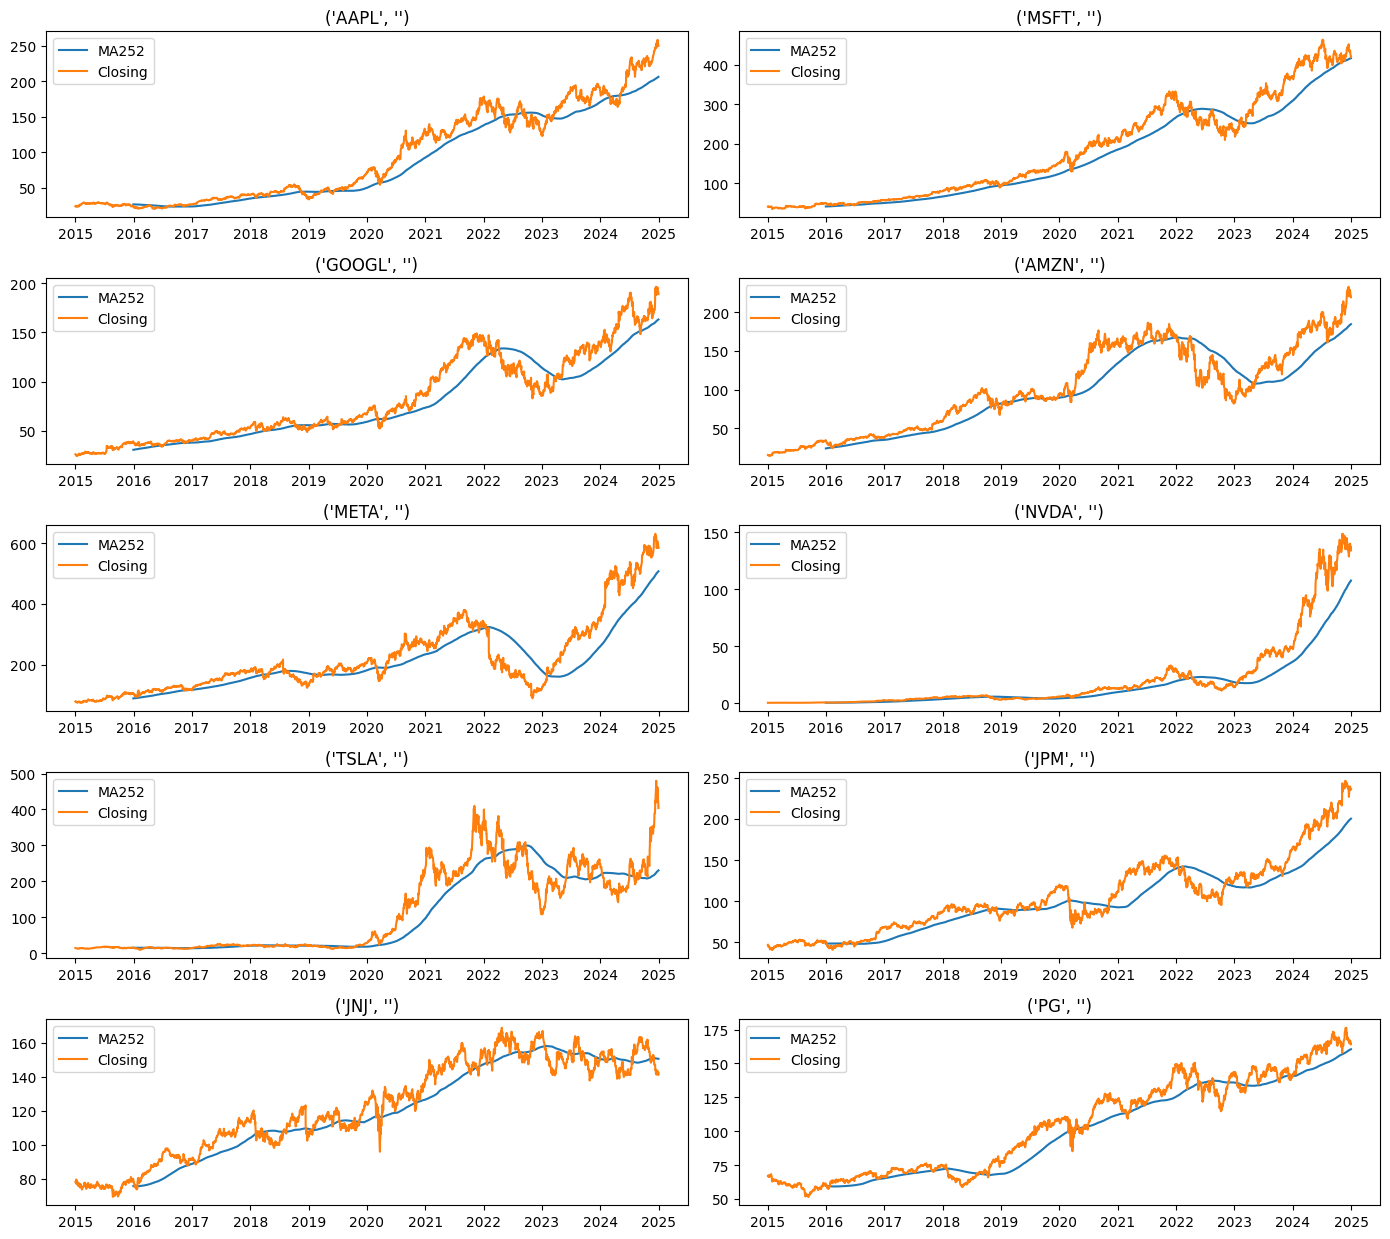

In [13]:
import math

n = len(df_close.columns)
rows = math.ceil(n/2)   # 2 plots per row
fig, axes = plt.subplots(rows, 2, figsize=(14, 2.5*rows))

for i, stock in enumerate(df_close.columns):
    ax = axes[i//2, i%2]
    ax.plot(movingAverage[stock], label="MA252")
    ax.plot(df_close[stock], label="Closing")
    ax.set_title(stock)
    ax.legend()

plt.tight_layout()
plt.show()


**Linear Regression and PCA**

In [14]:

# Here we create a wide dataset
raw_df = df.dropna().copy()

# Keep only numeric features (Close, High, Low, Volume, etc.)
raw_df = raw_df.set_index("Date")
raw_df = raw_df.swaplevel(axis=1)   # (Ticker, Feature) style
raw_df.sort_index(axis=1, inplace=True)

# Drop NA
raw_df = raw_df.dropna(axis=0)

raw_df = raw_df.to_numpy()
raw_df.shape


(2516, 50)

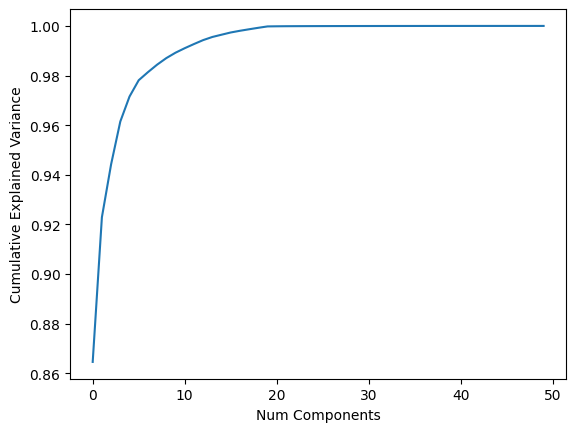

In [15]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

#Scaling the data
raw_df_scaled = MinMaxScaler().fit_transform(raw_df)

#Performing PCA ~ Reducing Dimensionality
PCA_model = PCA(n_components=50)
PCA_df = PCA_model.fit_transform(raw_df_scaled)

plt.plot(np.cumsum(PCA_model.explained_variance_ratio_))
plt.xlabel('Num Components')
plt.ylabel('Cumulative Explained Variance');


In [16]:
dates = df_close.index
stocks = df_close.columns
PC_labs = [f"PC{i+1}" for i in range(PCA_df.shape[1])]


**Tranning Data and Testing**

In [17]:
from sklearn.linear_model import LinearRegression

def predict_prices(raw_df, close, time, lookback, forward, stock_num):
    pca1 = PCA(n_components = 10)
    pca2 = PCA(n_components = 10)

    #Training data = t - forward - lookback
    X_train = raw_df[time-forward-lookback:time-forward,:]
    X_train = MinMaxScaler().fit_transform(X_train)
    X_train = pca1.fit_transform(X_train)
    y_train = close.iloc[time-forward+1:time+1,stock_num]

    #Testing = t - lookback
    X_test = raw_df[time-lookback:time,:]
    X_test = MinMaxScaler().fit_transform(X_test)
    X_test = pca2.fit_transform(X_test)
    y_test = close.iloc[time+1 : time+forward+1, stock_num]

    LR = LinearRegression()
    LR.fit(X_train, y_train)
    predicted = LR.predict(X_test)

    return predicted, y_test


def construct_prediction_tab(full_features_df, closing_prices_df):
    predictions = []
    actuals = []

    for stocks in range(closing_prices_df.shape[1]):
        stock_predictions = []
        stock_actuals = []

        for t in range(60, closing_prices_df.shape[0], 30):
            pred, act = predict_prices(full_features_df, closing_prices_df, t, 30, 30, stocks)
            stock_predictions.append(pred)
            stock_actuals.append(act)

        stock_predictions = np.concatenate(stock_predictions)
        stock_actuals = np.concatenate(stock_actuals)

        predictions.append(stock_predictions)
        actuals.append(stock_actuals)

    return predictions, actuals


In [18]:
pred, act = construct_prediction_tab(raw_df, df_close)


In [19]:
final_actuals = pd.DataFrame(data = act, index=stocks, columns = dates[61:]).transpose()
final_preds = pd.DataFrame(data = pred, index = stocks).transpose()

final_preds = final_preds.iloc[:len(final_actuals), :]
final_preds.index = dates[61:]

final_actuals.head()
#final_preds.head()


Price,AAPL,MSFT,GOOGL,AMZN,META,NVDA,TSLA,JPM,JNJ,PG
Ticker,,,,,,,,,,
Date,,,,,,,,,,
2015-04-01,27.680714,35.022385,27.310709,18.513000,81.224396,0.506125,12.506000,45.339176,74.522537,61.403156
2015-04-02,27.919085,34.652527,26.904148,18.612499,81.114983,0.507329,12.733333,45.770252,74.890839,61.485180
2015-04-06,28.371330,35.736237,27.035358,18.851999,81.990189,0.522024,13.540000,45.732437,74.530083,61.940189
2015-04-07,28.072805,35.719025,27.080587,18.720501,81.870842,0.526601,13.550000,46.019821,75.236572,61.455345
2015-04-08,27.981464,35.624420,27.278402,19.059999,81.831062,0.530455,13.844667,46.171078,75.281662,61.738796


In [20]:
final_preds.head()

Price,AAPL,MSFT,GOOGL,AMZN,META,NVDA,TSLA,JPM,JNJ,PG
Ticker,,,,,,,,,,
Date,,,,,,,,,,
2015-04-01,28.269533,36.147746,28.079071,18.865753,80.012403,0.557094,12.796337,46.830441,76.645315,62.453074
2015-04-02,27.682231,35.669123,28.290755,18.806582,80.044318,0.542510,12.801930,46.207759,76.044078,61.988060
2015-04-06,27.945365,35.103722,28.115151,18.750422,79.225753,0.546926,12.854036,46.339593,75.109523,61.269467
2015-04-07,28.073910,35.359193,28.193484,18.716195,79.568046,0.544513,12.979499,46.398142,75.317562,61.273429
2015-04-08,28.134372,36.154092,29.005781,18.776997,82.113644,0.552624,13.052050,46.214242,76.274738,61.851697


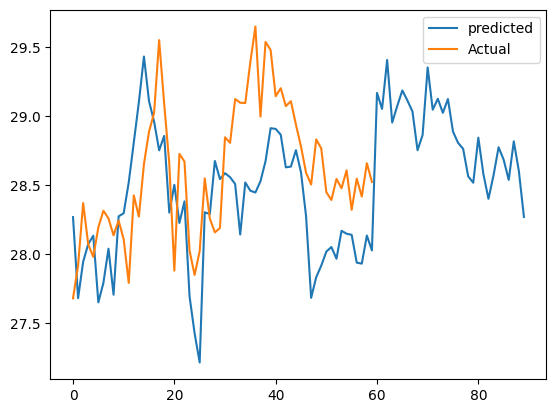

In [21]:
p1 , t1 = predict_prices(raw_df, df_close, 60, 30, 30, 0)
p2 , t2 = predict_prices(raw_df, df_close, 90, 30, 30, 0)
p3 , t3 = predict_prices(raw_df, df_close, 120, 30, 30, 0)

predictions = np.concatenate([p1,p2,p3])
actuals = np.concatenate((t1,t2))

plt.plot(predictions, label = 'predicted')
plt.plot(actuals, label = 'Actual')
plt.legend()
plt.show()

In [22]:
# Calculate the 252-day moving average
movingAverage = df_close.rolling(window=252).mean()

**QQ-Plot**

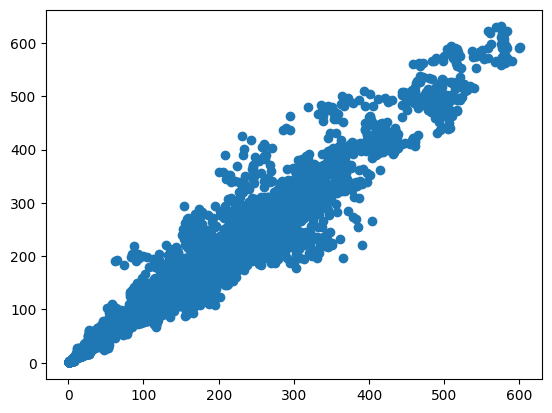

In [24]:
# Q-Q plot for predictions vs actuals
plt.scatter(x = final_preds[:4966], y = final_actuals)

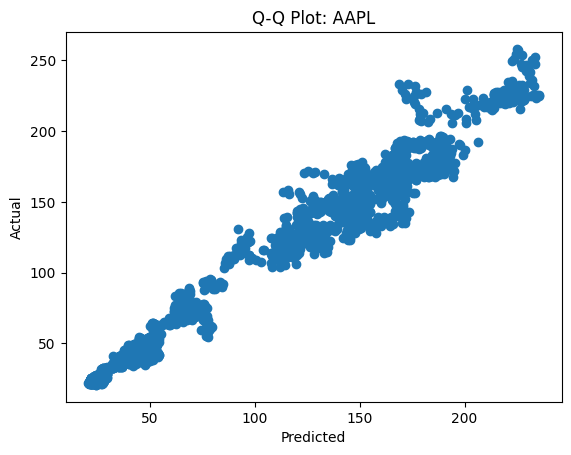

In [25]:
stock = "AAPL"
plt.scatter(final_preds[stock], final_actuals[stock])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Q-Q Plot: {stock}")
plt.show()


**Full Prediction of all 10 Stocks vs Actual**

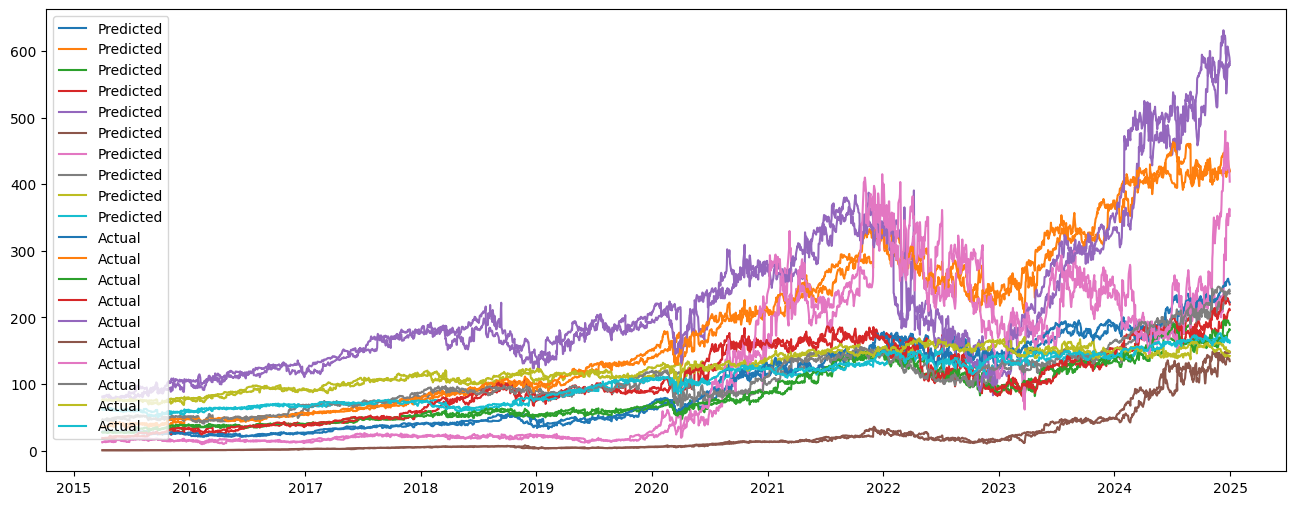

In [26]:
#Full Prediction vs Actuals for the same stock
plt.figure(figsize=(16,6))
plt.plot(final_preds, label = 'Predicted')
plt.plot(final_actuals, label = 'Actual')
plt.legend()

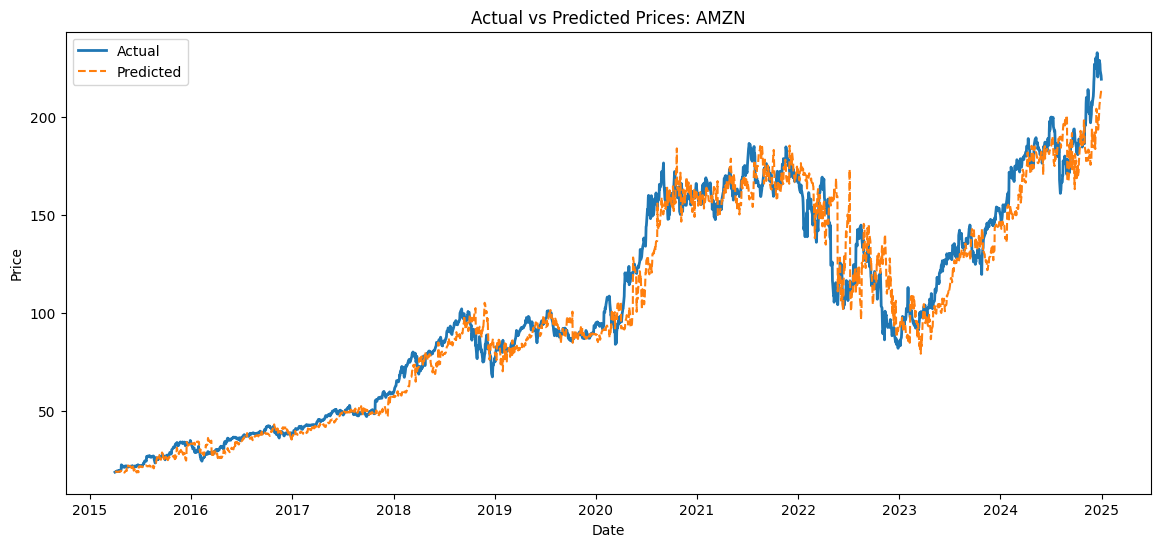

In [27]:
stock = "AMZN"   # choose ticker

plt.figure(figsize=(14,6))
plt.plot(final_actuals.index, final_actuals[stock], label="Actual", linewidth=2)
plt.plot(final_preds.index, final_preds[stock], label="Predicted", linestyle="--")
plt.title(f"Actual vs Predicted Prices: {stock}")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()


**Portfolio Average**

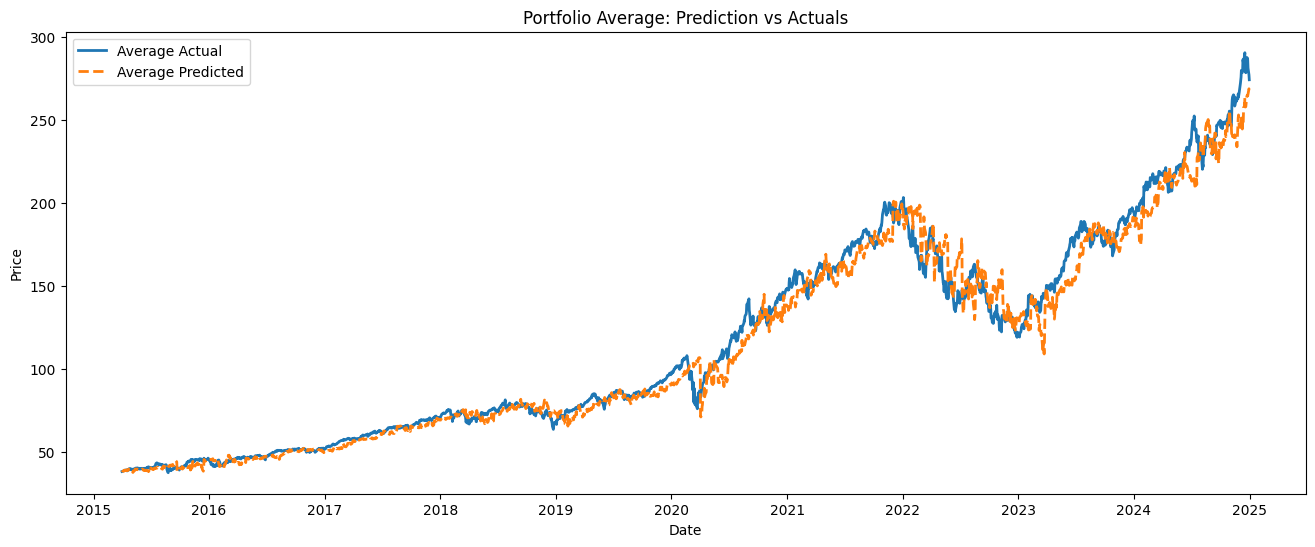

In [28]:
plt.figure(figsize=(16,6))
plt.plot(final_actuals.index, final_actuals.mean(axis=1), label="Average Actual", linewidth=2)
plt.plot(final_preds.index, final_preds.mean(axis=1), label="Average Predicted", linewidth=2, linestyle="--")
plt.title("Portfolio Average: Prediction vs Actuals")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()


**Finding Mean Absolute Error (MAE)**

In [29]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(final_actuals, final_preds)
mae


9.021553793746664

In [30]:
mape = (np.abs(final_actuals - final_preds) / final_actuals).mean().mean() * 100
print("MAPE:", mape, "%")

MAPE: 7.881945887852318 %


In [31]:
from sklearn.metrics import mean_absolute_error

mae_per_stock = {}
for stock in final_actuals.columns:
    mae = mean_absolute_error(final_actuals[stock], final_preds[stock])
    mae_per_stock[stock] = mae

mae_df = pd.DataFrame.from_dict(mae_per_stock, orient='index', columns=['MAE'])
print(mae_df)


                 MAE
(AAPL, )    6.969798
(MSFT, )   10.964386
(GOOGL, )   5.684157
(AMZN, )    8.079777
(META, )   19.650475
(NVDA, )    2.919196
(TSLA, )   19.833516
(JPM, )     6.631058
(JNJ, )     5.021639
(PG, )      4.461535


              MAE       RMSE     MAPE %        R²
AAPL     6.969798  10.484122   7.471730  0.974325
MSFT    10.964386  16.392851   5.759563  0.982109
GOOGL    5.684157   8.137454   6.480603  0.964437
AMZN     8.079777  11.721350   8.032682  0.951423
META    19.650475  29.571267   8.884281  0.939884
NVDA     2.919196   6.649041  12.894450  0.958264
TSLA    19.833516  35.630844  14.713911  0.903092
JPM      6.631058   9.319974   6.276868  0.956032
JNJ      5.021639   6.643292   4.028139  0.939973
PG       4.461535   5.989830   4.277231  0.970761


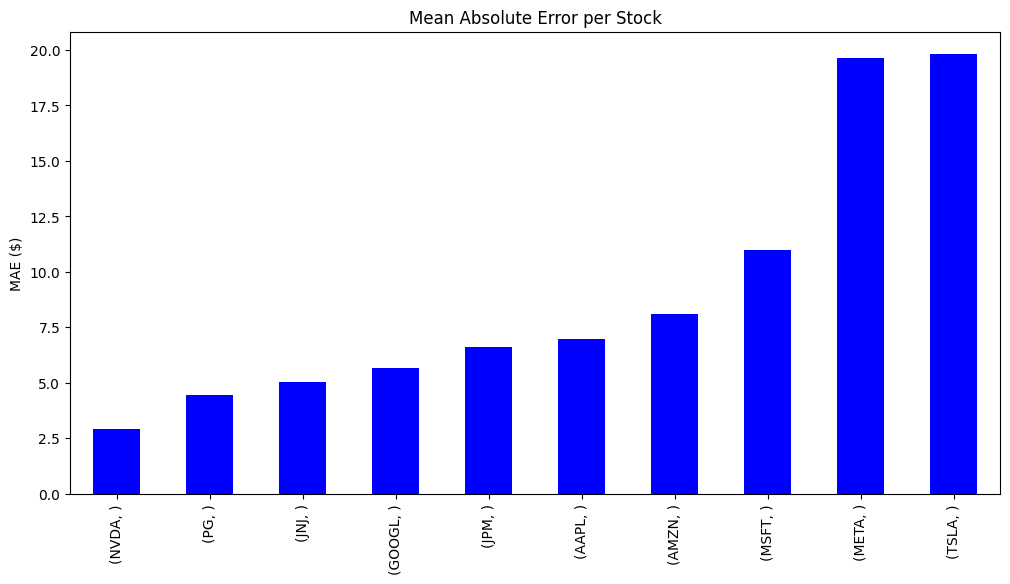

In [32]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

metrics = {}
for stock in final_actuals.columns:
    y_true = final_actuals[stock]
    y_pred = final_preds[stock]
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = (np.abs((y_true - y_pred) / y_true)).mean() * 100
    r2 = r2_score(y_true, y_pred)
    metrics[stock] = [mae, rmse, mape, r2]

metrics_df = pd.DataFrame(metrics, index=['MAE','RMSE','MAPE %','R²']).T
print(metrics_df)


metrics_df['MAE'].sort_values().plot(kind='bar', figsize=(12,6), color='blue')
plt.title("Mean Absolute Error per Stock")
plt.ylabel("MAE ($)")
plt.show()

**What if we had invested $1000 per stock for the peried of 20 years so what return we could expact**

In [33]:
# make sure df_close has 20+ years of daily prices
start_date = df_close.index.min()
end_date = df_close.index.max()
n_years = (end_date - start_date).days / 365.25

cagr_results = {}
investment = 1000  # starting investment per stock

for stock in df_close.columns:
    P_start = df_close[stock].iloc[0]
    P_end = df_close[stock].iloc[-1]

    cagr = (P_end / P_start) ** (1/n_years) - 1
    final_value = investment * ((1 + cagr) ** n_years)

    cagr_results[stock] = {
        "Start Price": P_start,
        "End Price": P_end,
        "CAGR %": cagr * 100,
        "Final Value ($1000 invested)": final_value
    }

cagr_df = pd.DataFrame(cagr_results).T
print(cagr_df)

        Start Price   End Price     CAGR %  Final Value ($1000 invested)
AAPL      24.261042  249.534180  26.259378                  10285.386068
MSFT      39.933060  419.196564  26.517460                  10497.481709
GOOGL     26.319653  188.853607  21.792256                   7175.383747
AMZN      15.426000  219.389999  30.419857                  14222.092862
META      78.021957  584.539795  22.319489                   7491.990901
NVDA       0.483066  134.268326  75.588939                 277950.498587
TSLA      14.620667  403.839996  39.374533                  27621.173760
JPM       46.948082  235.882034  17.526690                   5024.316743
JNJ       78.012611  142.252045   6.194027                   1823.449339
PG        66.983513  164.476852   9.403122                   2455.482631


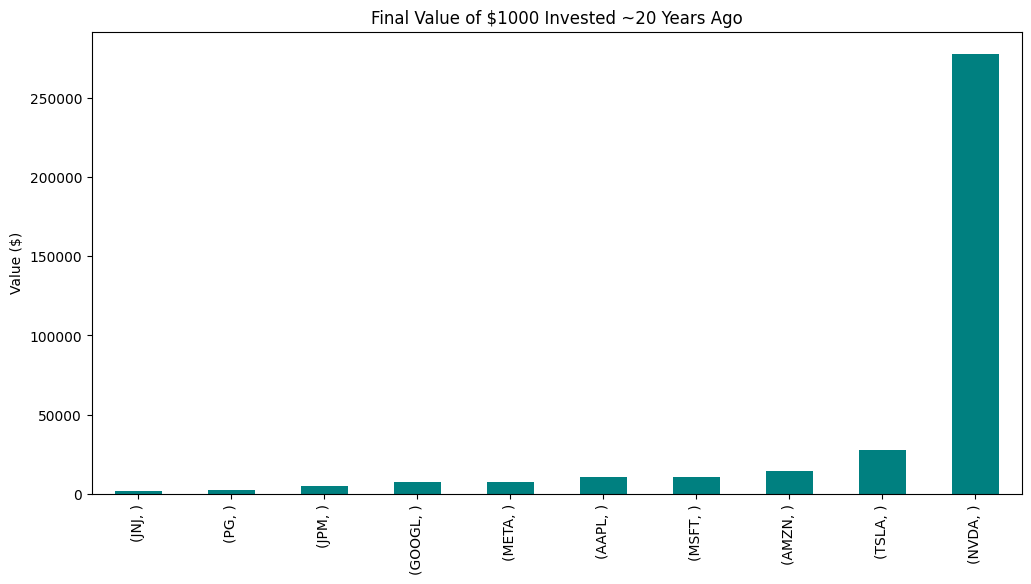

In [34]:
cagr_df["Final Value ($1000 invested)"].sort_values().plot(kind="bar", figsize=(12,6), color="teal")
plt.title("Final Value of $1000 Invested ~20 Years Ago")
plt.ylabel("Value ($)")
plt.show()


In [35]:

# Set basics
tickers = list(df_close.columns)
initial_total = 10_000
w = np.repeat(1/len(tickers), len(tickers))  # equal weights

# Compute daily returns for each stock
rets = df_close.pct_change().dropna()

# Equal-weighted portfolio daily return = weighted average of stock returns
port_ret = (rets * w).sum(axis=1)

# Cumulative growth of $10,000
port_cum = (1 + port_ret).cumprod()
portfolio_final_value = initial_total * port_cum.iloc[-1]

# Portfolio CAGR
n_years = (port_cum.index[-1] - port_cum.index[0]).days / 365.25
portfolio_cagr = (portfolio_final_value / initial_total) ** (1/n_years) - 1

print(f"Portfolio Final Value ($10,000 total): ${portfolio_final_value:,.2f}")
print(f"Portfolio CAGR: {portfolio_cagr*100:.2f}%")

# Compare with SPY
spy_series = yf.download("SPY", start=df_close.index.min(), end=df_close.index.max())["Close"].dropna()

spy_ret = spy_series.pct_change().dropna()
spy_cum = (1 + spy_ret).cumprod()
spy_final_value = initial_total * spy_cum.iloc[-1]
spy_cagr = (spy_final_value / initial_total) ** (1/n_years) - 1

print(f"SPY Final Value ($10,000): ${spy_final_value.iloc[0]:,.2f}")
print(f"SPY CAGR: {spy_cagr.iloc[0]*100:.2f}%")

# Per-stock $1,000 growth table
per_stock_initial = initial_total / len(tickers)
growth_factor = df_close.iloc[-1] / df_close.iloc[0]
per_stock_final = per_stock_initial * growth_factor

per_stock_df = pd.DataFrame({
    "Start Price": df_close.iloc[0],
    "End Price": df_close.iloc[-1],
    "Growth Factor": growth_factor,
    "Final Value ($1,000 each)": per_stock_final
}).round(2)

print(per_stock_df)

Portfolio Final Value ($10,000 total): $145,262.68
Portfolio CAGR: 30.73%


/tmp/ipython-input-2979387112.py:32: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy_series = yf.download("SPY", start=df_close.index.min(), end=df_close.index.max())["Close"].dropna()
[*********************100%***********************]  1 of 1 completed

SPY Final Value ($10,000): $34,081.35
SPY CAGR: 13.06%
              Start Price  End Price  Growth Factor  Final Value ($1,000 each)
Price Ticker                                                                  
AAPL                24.26     249.53          10.29                   10285.39
MSFT                39.93     419.20          10.50                   10497.48
GOOGL               26.32     188.85           7.18                    7175.38
AMZN                15.43     219.39          14.22                   14222.09
META                78.02     584.54           7.49                    7491.99
NVDA                 0.48     134.27         277.95                  277950.50
TSLA                14.62     403.84          27.62                   27621.17
JPM                 46.95     235.88           5.02                    5024.32
JNJ                 78.01     142.25           1.82                    1823.45
PG                  66.98     164.48           2.46                    2455.

In [48]:
# Start and end prices
P_start = spy.iloc[0]
P_end = spy.iloc[-1]

# Years in sample
n_years = (spy.index[-1] - spy.index[0]).days / 365.25

# CAGR for SPY
spy_cagr = (P_end / P_start) ** (1/n_years) - 1

# If we invested the same $10,000
spy_final_value = 10000 * ((1 + spy_cagr) ** n_years)

print("SPY CAGR %:", round(spy_cagr*100, 2))
print("SPY Final Value ($10,000 invested):", round(spy_final_value, 2))

# Compare Portfolio vs SPY
print("\nPortfolio Final Value ($10,000 invested):", round(portfolio_final_value, 2))
print("Portfolio CAGR %:", round(portfolio_cagr*100, 2))


SPY CAGR %: Ticker
SPY    13.05
dtype: float64
SPY Final Value ($10,000 invested): Ticker
SPY    34081.35
dtype: float64

Portfolio Final Value ($10,000 invested): 145262.68
Portfolio CAGR %: 30.73


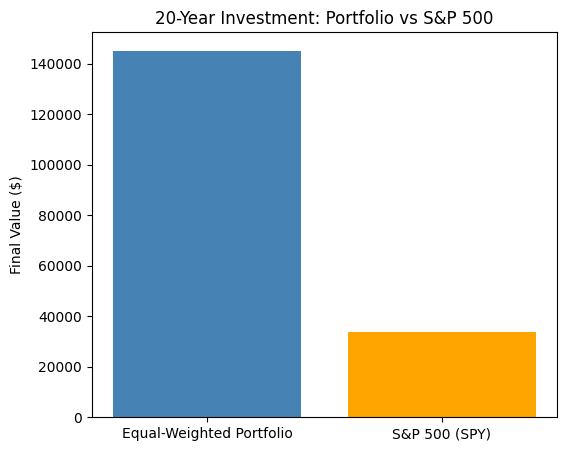

In [37]:
plt.figure(figsize=(6,5))
bars = plt.bar(["Equal-Weighted Portfolio", "S&P 500 (SPY)"],
               [portfolio_final_value, spy_final_value.iloc[0]],
               color=["steelblue","orange"])
plt.title("20-Year Investment: Portfolio vs S&P 500")
plt.ylabel("Final Value ($)")
plt.show()

/tmp/ipython-input-3118767411.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy = yf.download("SPY", start=df_close.index.min(), end=df_close.index.max())["Close"]
[*********************100%***********************]  1 of 1 completed


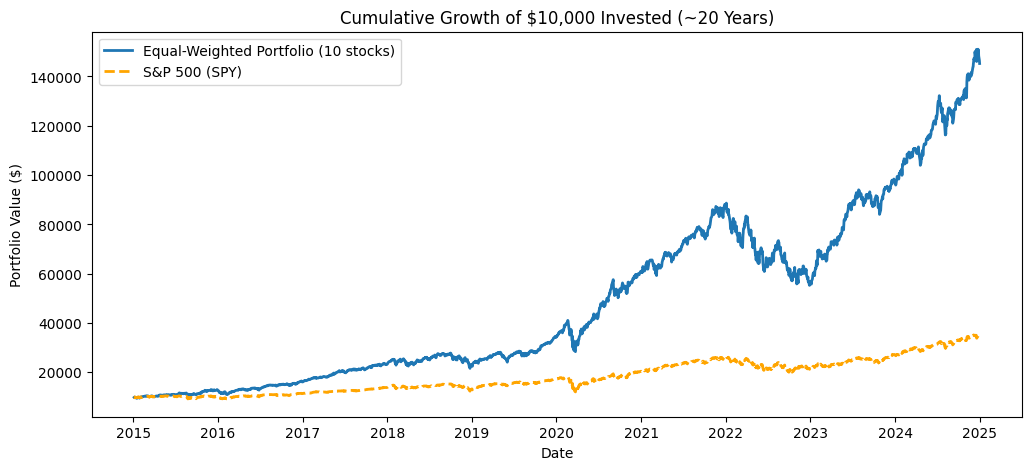

In [38]:
# Daily returns for portfolio stocks
stock_returns = df_close.pct_change().dropna()

# Equal-weighted portfolio (average of all stock returns)
portfolio_returns = stock_returns.mean(axis=1)

# Cumulative portfolio value (start with $10,000)
initial_investment = 10000
portfolio_cum = (1 + portfolio_returns).cumprod() * initial_investment

# SPY cumulative value
spy = yf.download("SPY", start=df_close.index.min(), end=df_close.index.max())["Close"]
spy_returns = spy.pct_change().dropna()
spy_cum = (1 + spy_returns).cumprod() * initial_investment

# Plot
plt.figure(figsize=(12,5))
plt.plot(portfolio_cum, label="Equal-Weighted Portfolio (10 stocks)", linewidth=2)
plt.plot(spy_cum, label="S&P 500 (SPY)", linewidth=2, linestyle="--", color="orange")
plt.title("Cumulative Growth of $10,000 Invested (~20 Years)")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.show()


In [42]:
vol_df = pd.DataFrame({
    "Daily Volatility": df_returns.std(),
    "Annualized Volatility": df_returns.std() * np.sqrt(252)
}).round(4)

print(vol_df)


              Daily Volatility  Annualized Volatility
Price Ticker                                         
AAPL                    0.0179                 0.2847
MSFT                    0.0171                 0.2713
GOOGL                   0.0179                 0.2842
AMZN                    0.0206                 0.3266
META                    0.0238                 0.3786
NVDA                    0.0304                 0.4822
TSLA                    0.0359                 0.5701
JPM                     0.0172                 0.2732
JNJ                     0.0114                 0.1808
PG                      0.0116                 0.1846


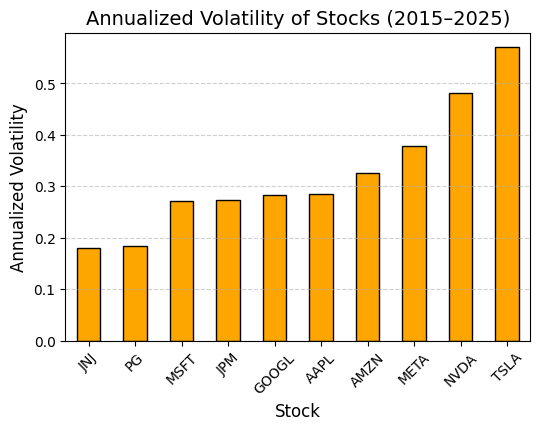

In [43]:
# Your volatility data
vol_df = pd.DataFrame({
    "Daily Volatility": [0.0179, 0.0171, 0.0179, 0.0206, 0.0238, 0.0304, 0.0359, 0.0172, 0.0114, 0.0116],
    "Annualized Volatility": [0.2847, 0.2713, 0.2842, 0.3266, 0.3786, 0.4822, 0.5701, 0.2732, 0.1808, 0.1846]
}, index=["AAPL","MSFT","GOOGL","AMZN","META","NVDA","TSLA","JPM","JNJ","PG"])

# Plot annualized volatility
plt.figure(figsize=(6,4))
vol_df["Annualized Volatility"].sort_values().plot(kind="bar", color="orange", edgecolor="black")

plt.title("Annualized Volatility of Stocks (2015–2025)", fontsize=14)
plt.ylabel("Annualized Volatility", fontsize=12)
plt.xlabel("Stock", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()
